# **Financial Agent**

In [ ]:
import yfinance as yf

# Define refined scoring thresholds, more aligned with tech sector averages
THRESHOLDS = {
    "P/E": 40,               # Adjusted to accommodate high P/E for tech stocks
    "P/B": 25,               # Higher threshold for tech
    "PEG": 2.0,              # Moderate PEG threshold to account for growth expectations
    "Dividend Yield": 0.004  # Minimum threshold for dividend yield
}

# Get user input for tickers
TICKERS = input("Enter stock tickers separated by commas: ").split(",")

# Get stock data
def get_stock_data(ticker):
    stock = yf.Ticker(ticker.strip())
    info = stock.info
    try:
        price = stock.history(period='1d')['Close'].iloc[0]  # Use `iloc` for latest price
    except IndexError:
        print(f"No data for {ticker}, skipping.")
        return None

    eps = info.get("trailingEps", 0)
    book_value = info.get("bookValue", 0)
    dividend_per_share = info.get("dividendRate", 0)
    annual_growth = info.get("revenueGrowth", 0)

    return {
        "price": price,
        "eps": eps,
        "book_value": book_value,
        "dividend_per_share": dividend_per_share,
        "annual_growth": annual_growth
    }

# Calculate financial ratios
def calculate_ratios(data):
    pe_ratio = data['price'] / data['eps'] if data['eps'] > 0 else float('inf')
    pb_ratio = data['price'] / data['book_value'] if data['book_value'] > 0 else float('inf')
    peg_ratio = pe_ratio / (data['annual_growth'] * 100) if data['annual_growth'] > 0 else float('inf')
    dividend_yield = data['dividend_per_share'] / data['price'] if data['price'] > 0 else 0

    return {
        "P/E": pe_ratio,
        "P/B": pb_ratio,
        "PEG": peg_ratio,
        "Dividend Yield": dividend_yield
    }

# Score ratios with scaling adjustments
def score_ratios(ratios):
    score = 0
    if ratios["P/E"] <= THRESHOLDS["P/E"]:
        score += 1
    if ratios["P/B"] <= THRESHOLDS["P/B"]:
        score += 1
    if ratios["PEG"] <= THRESHOLDS["PEG"]:
        score += 1
    if ratios["Dividend Yield"] >= THRESHOLDS["Dividend Yield"]:
        score += 1

    # Ensure minimum score if at least one metric meets the threshold
    if score == 0 and any(
        ratios[key] <= THRESHOLDS[key] if key != "Dividend Yield" else ratios[key] >= THRESHOLDS[key]
        for key in ratios
    ):
        score = 1

    # Convert to 10-point and 100-point scales
    score_10 = score * 2.5
    score_100 = score * 25

    return score, score_10, score_100

# Main function
def main():
    scores = {}
    for ticker in TICKERS:
        data = get_stock_data(ticker)
        if data is None:
            continue  # Skip if no data

        print(f"\nData for {ticker.strip()}: {data}")

        ratios = calculate_ratios(data)
        print(f"Ratios for {ticker.strip()}: {ratios}")

        score_4, score_10, score_100 = score_ratios(ratios)
        scores[ticker.strip()] = {
            "Score (out of 4)": score_4,
            "Score (out of 10)": score_10,
            "Score (out of 100)": score_100
        }

    print("\nFinancial Indicator Scores:")
    for ticker, score_details in scores.items():
        print(f"{ticker}: {score_details}")

if __name__ == "__main__":
    main()


Enter stock tickers separated by commas: TSLA

Data for TSLA: {'price': np.float64(252.30999755859375), 'eps': 2.04, 'book_value': 22.672, 'dividend_per_share': 0, 'annual_growth': 0.021}
Ratios for TSLA: {'P/E': np.float64(123.68137135225183), 'P/B': np.float64(11.128704902901982), 'PEG': np.float64(58.89589112011992), 'Dividend Yield': np.float64(0.0)}

Financial Indicator Scores:
TSLA: {'Score (out of 4)': 1, 'Score (out of 10)': 2.5, 'Score (out of 100)': 25}


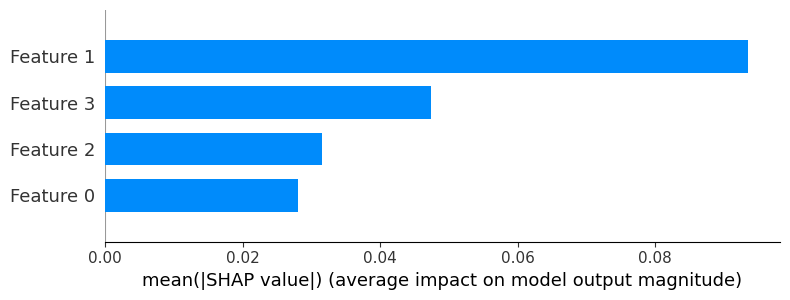

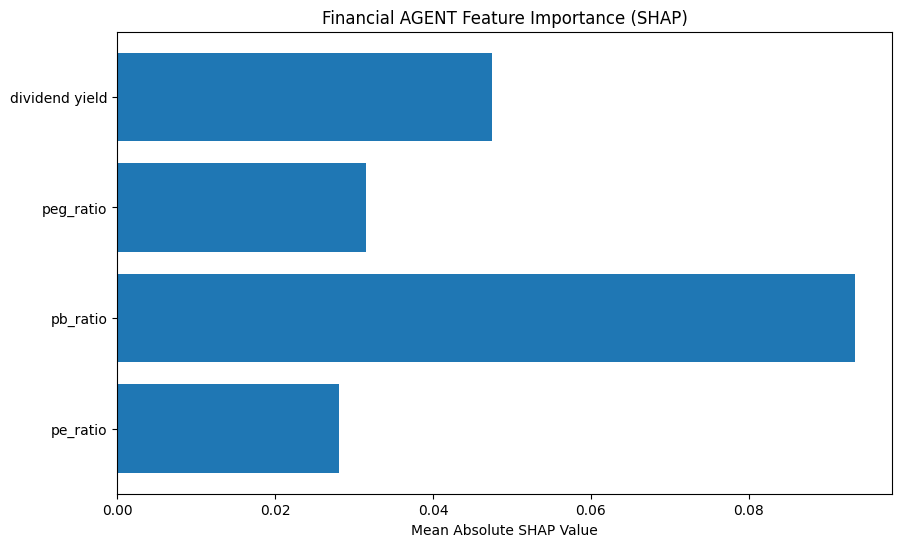

In [ ]:
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import yfinance as yf
import numpy as np

# Example data (replace this with your actual feature extraction logic)
# Assuming features are calculated and stored in X, and target is y (stock credibility score)
def get_features():
    # Example data: replace with your actual features like P/E, P/B, etc.
    features = np.random.rand(100, 4)  # Random features for illustration
    return features

X = np.array(get_features())  # Features for model training
y = np.random.rand(100)  # Random target for illustration

# Train a model (RandomForestRegressor for example)
model = RandomForestRegressor(n_estimators=100)
model.fit(X, y)

# Use SHAP to explain the model's predictions
explainer = shap.TreeExplainer(model)  # For tree-based models
shap_values = explainer.shap_values(X)

# Get the feature importance and plot a horizontal bar graph
shap.summary_plot(shap_values, X, plot_type="bar")  # This automatically gives a bar plot

# Alternatively, if you want a custom horizontal bar plot:
importance_values = np.abs(shap_values).mean(axis=0)  # Mean absolute SHAP value
feature_names = ['pe_ratio', 'pb_ratio', 'peg_ratio', 'dividend yield']  # Replace with actual feature names

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importance_values)
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Financial AGENT Feature Importance (SHAP)")
plt.show()


## **Industry Trend Agent**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

class IndustryTrendAnalyzer:
    def __init__(self, ticker):
        self.ticker = ticker
        self.stock_data = self.fetch_stock_data()
        self.financials = self.fetch_financials()

    def fetch_stock_data(self):
        # Fetch historical market data
        stock = yf.Ticker(self.ticker)
        return stock.history(period='1y')

    def fetch_financials(self):
        # Fetch financial statements
        stock = yf.Ticker(self.ticker)
        return stock.financials, stock.balance_sheet

    def calculate_durability_score(self):
        # Ensure revenue data is valid and numeric
        revenue = pd.to_numeric(self.financials[0].loc['Total Revenue'], errors='coerce').dropna()
        if revenue.empty:
            return 0  # Return a default score if revenue data is unavailable

        # Update pct_change to explicitly specify no fill method
        revenue_change = revenue.pct_change(fill_method=None).std()  # Standard deviation of revenue growth
        score = max(0, 100 - (revenue_change * 100))  # Higher stability leads to higher score
        return score

    def calculate_valuation_score(self):
    # Ensure 'Gross Profit' and 'Net Income' data are valid and numeric
            gross_profit = pd.to_numeric(self.financials[0].loc['Gross Profit'], errors='coerce').dropna()
            net_income = pd.to_numeric(self.financials[0].loc['Net Income'], errors='coerce').dropna()

            if gross_profit.empty or net_income.empty:
                return 0  # Return a default score if data is unavailable

            # Calculate P/E ratio (handle potential division issues)
            pe_ratio = gross_profit / net_income
            pe_ratio = pe_ratio.mean()  # Take the mean value if it is a Series

            if pe_ratio < 15:
                return 80  # Undervalued
            elif pe_ratio < 25:
                return 50  # Fairly valued
            else:
                return 20  # Overvalued


    def calculate_momentum_score(self):
        # Calculate a momentum score based on recent price trends
        recent_returns = self.stock_data['Close'].pct_change().dropna()
        momentum_score = np.mean(recent_returns) * 100  # Convert to percentage
        return max(0, min(100, momentum_score))  # Clamp between 0 and 100

    def get_industry_trend_score(self):
        durability_score = self.calculate_durability_score()
        valuation_score = self.calculate_valuation_score()
        momentum_score = self.calculate_momentum_score()

        # Aggregate scores with weights (you can adjust weights as needed)
        overall_score = (durability_score * 0.4) + (valuation_score * 0.4) + (momentum_score * 0.2)

        return {
            'Durability Score': durability_score,
            'Valuation Score': valuation_score,
            'Momentum Score': momentum_score,
            'Overall Industry Trend Score': overall_score
        }

if __name__ == "__main__":
    user_input_ticker = input("Enter the stock ticker symbol: ")
    analyzer = IndustryTrendAnalyzer(user_input_ticker)
    scores = analyzer.get_industry_trend_score()

    print("\nIndustry Trend Analysis Scores:")
    for key, value in scores.items():
        print(f"{key}: {value:.2f}")


Enter the stock ticker symbol: ZOMATO.BO

Industry Trend Analysis Scores:
Durability Score: 93.18
Valuation Score: 80.00
Momentum Score: 0.36
Overall Industry Trend Score: 69.34


In [ ]:
!pip install lime shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4b7117ab5da94bb5461b14788f7e55ddae9451e5e1ea22a0b002d0e8969a032d
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


Enter the stock ticker symbol: TSLA

Industry Trend Analysis Scores:
Durability Score: 86.84
Valuation Score: 80.00
Momentum Score: 0.20
Overall Industry Trend Score: 66.78
Input data for SHAP: [[86.84407076 80.          0.19841281]]
SHAP values: [[34.33762831 31.6        -0.16031744]]


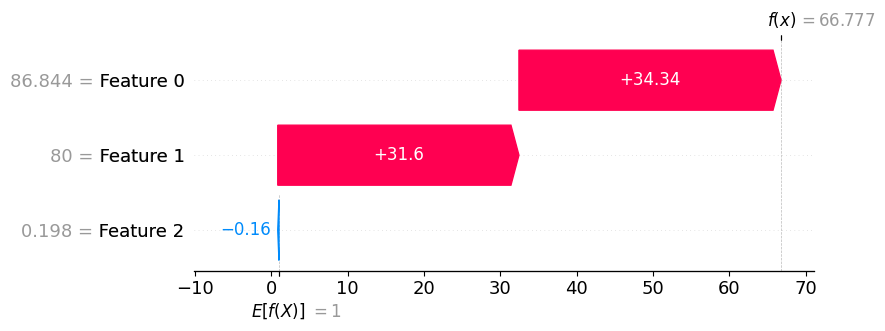

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

class IndustryTrendAnalyzer:
    def __init__(self, ticker):
        self.ticker = ticker
        self.stock_data = self.fetch_stock_data()
        self.financials = self.fetch_financials()

    def fetch_stock_data(self):
        # Fetch historical market data
        stock = yf.Ticker(self.ticker)
        return stock.history(period='1y')

    def fetch_financials(self):
        # Fetch financial statements
        stock = yf.Ticker(self.ticker)
        return stock.financials, stock.balance_sheet

    def calculate_durability_score(self):
        # Ensure revenue data is valid and numeric
        revenue = pd.to_numeric(self.financials[0].loc['Total Revenue'], errors='coerce').dropna()
        if revenue.empty:
            return 0  # Return a default score if revenue data is unavailable

        revenue_change = revenue.pct_change(fill_method=None).std()  # Standard deviation of revenue growth
        score = max(0, 100 - (revenue_change * 100))  # Higher stability leads to higher score
        return score

    def calculate_valuation_score(self):
        # Ensure 'Gross Profit' and 'Net Income' data are valid and numeric
        gross_profit = pd.to_numeric(self.financials[0].loc['Gross Profit'], errors='coerce').dropna()
        net_income = pd.to_numeric(self.financials[0].loc['Net Income'], errors='coerce').dropna()

        if gross_profit.empty or net_income.empty:
            return 0  # Return a default score if data is unavailable

        pe_ratio = gross_profit / net_income
        pe_ratio = pe_ratio.mean()  # Take the mean value if it is a Series

        if pe_ratio < 15:
            return 80  # Undervalued
        elif pe_ratio < 25:
            return 50  # Fairly valued
        else:
            return 20  # Overvalued

    def calculate_momentum_score(self):
        # Calculate a momentum score based on recent price trends
        recent_returns = self.stock_data['Close'].pct_change().dropna()
        momentum_score = np.mean(recent_returns) * 100  # Convert to percentage
        return max(0, min(100, momentum_score))  # Clamp between 0 and 100

    def get_industry_trend_score(self):
        durability_score = self.calculate_durability_score()
        valuation_score = self.calculate_valuation_score()
        momentum_score = self.calculate_momentum_score()

        overall_score = (durability_score * 0.4) + (valuation_score * 0.4) + (momentum_score * 0.2)
        return {
            'Durability Score': durability_score,
            'Valuation Score': valuation_score,
            'Momentum Score': momentum_score,
            'Overall Industry Trend Score': overall_score
        }

def explain_scores(scores):
    input_data = np.array([[
        scores['Durability Score'],
        scores['Valuation Score'],
        scores['Momentum Score']
    ]])

    # Print input data for debugging purposes
    print("Input data for SHAP:", input_data)

    # Model function for prediction
    def model_predict(data):
        return (data[:, 0] * 0.4) + (data[:, 1] * 0.4) + (data[:, 2] * 0.2)

    # Ensure input shape matches expectations
    if input_data.shape[1] != 3:
        print("Invalid input shape for SHAP explanation.")
        return

    try:
        # Using a fixed background dataset for SHAP explainability
        explainer = shap.Explainer(model_predict, np.ones_like(input_data))
        shap_values = explainer(input_data)

        print("SHAP values:", shap_values.values)

        # Safeguard plot creation
        plt.figure(figsize=(10, 5))
        shap.waterfall_plot(shap_values[0])
        plt.show()
        plt.close()

    except ValueError as e:
        print("Plotting error:", e)
        plt.figure()
        plt.text(0.5, 0.5, 'Error in SHAP plot generation', ha='center', va='center')
        plt.show()
        plt.close()




if __name__ == "__main__":
    user_input_ticker = input("Enter the stock ticker symbol: ")
    analyzer = IndustryTrendAnalyzer(user_input_ticker)
    scores = analyzer.get_industry_trend_score()

    print("\nIndustry Trend Analysis Scores:")
    for key, value in scores.items():
        print(f"{key}: {value:.2f}")

    # Add explainability
    explain_scores(scores)

# **Fundamental agent**

In [ ]:
!pip install langchain transformers
!pip install langchain_community
!pip install --upgrade langchain
!pip uninstall torch
!pip install --upgrade pip
!pip install torch==2.1.0+cpu  # Or try the nightly version


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36
Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchfrtrace
    /usr/local/bin/torchrun
    /usr/local/lib/python3.10/dist-packages/functorch/*
    /usr/local/lib/python3.10/dist-packages/torch-2.5.1+cu121.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torch/*
    /usr/local/lib/python3.10/dist-packages/torchgen/*
Proceed (Y/n)? Y
Y



ERROR: Operation cancelled by user
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 56.7 MB/s

In [ ]:

from langchain.llms import HuggingFacePipeline


In [ ]:
import yfinance as yf
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import concurrent.futures
import time

# Load model and tokenizer directly for faster execution
model_name = "distilgpt2"  # Use a smaller, faster model for better performance
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create a Hugging Face pipeline with explicit generation parameters (CPU)
transformers_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=512,
    pad_token_id=50256,
    max_new_tokens=150,
    device=-1  # CPU by default, change to device=0 for GPU
)

# Function to fetch stock data
def fetch_stock_data(ticker):
    stock = yf.Ticker(ticker)
    info = stock.info
    data = {
        "revenue_growth": info.get("revenueGrowth", None),
        "net_profit_margin": info.get("profitMargins", None),
        "debt_to_equity_ratio": info.get("debtToEquity", None),
        "return_on_equity": info.get("returnOnEquity", None),
        "current_ratio": info.get("currentRatio", None)
    }
    return data

# Function to calculate stock score
def calculate_stock_score(stock_data):
    score = 0

    # Revenue Growth - Consider 10% as strong
    if stock_data["revenue_growth"] is not None:
        if stock_data["revenue_growth"] > 0.1:
            score += 30  # Strong growth adds 30 points
        elif stock_data["revenue_growth"] > 0:
            score += 15  # Moderate growth adds 15 points

    # Net Profit Margin - Consider 20% as excellent
    if stock_data["net_profit_margin"] is not None:
        if stock_data["net_profit_margin"] > 0.2:
            score += 25  # Excellent profit margin adds 25 points
        elif stock_data["net_profit_margin"] > 0.1:
            score += 15  # Good profit margin adds 15 points

    # Debt to Equity Ratio - Anything less than 1 is great
    if stock_data["debt_to_equity_ratio"] is not None:
        if stock_data["debt_to_equity_ratio"] < 1:
            score += 20  # Low debt is ideal
        elif stock_data["debt_to_equity_ratio"] < 2:
            score += 10  # Moderate debt adds points but less than low debt

    # Return on Equity (ROE) - 15% is great
    if stock_data["return_on_equity"] is not None:
        if stock_data["return_on_equity"] > 0.15:
            score += 30  # Strong ROE adds 30 points
        elif stock_data["return_on_equity"] > 0.1:
            score += 15  # Moderate ROE adds 15 points

    # Current Ratio - Anything above 1.5 is good
    if stock_data["current_ratio"] is not None:
        if stock_data["current_ratio"] > 1.5:
            score += 15  # Good liquidity adds 15 points
        elif stock_data["current_ratio"] > 1:
            score += 5  # Moderate liquidity adds 5 points

    # Normalize the score between 0 and 100
    score = min(max(score, 0), 100)

    return score

# Function to analyze stock data using the model
def analyze_stock_data(ticker):
    stock_data = fetch_stock_data(ticker)
    score = calculate_stock_score(stock_data)  # Get stock score based on data

    # Run the language model to analyze the stock data
    prompt = f"Analyze the following stock data for {ticker}: {stock_data}. The stock score is {score}. Provide a textual analysis."

    result = transformers_pipeline(prompt)
    analysis = result[0]["generated_text"]

    return score, analysis

# Function to analyze multiple stocks in parallel
def analyze_multiple_stocks(tickers):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = executor.map(analyze_stock_data, tickers)
    return list(results)

# Profiling the execution time of each task
def profile_analysis(tickers):
    start = time.time()
    results = analyze_multiple_stocks(tickers)
    print(f"Total analysis time: {time.time() - start:.2f} seconds")
    return results

# Example: Random S&P 500 stock tickers
user_input = input("Enter stock tickers (comma separated): ")
tickers = [ticker.strip().upper() for ticker in user_input.split(",")] # Modify to include random tickers

# Run the analysis
results = profile_analysis(tickers)

# Print the results of stock analysis with score
for ticker, (score, analysis) in zip(tickers, results):
    print(f"\nAnalysis for {ticker} (Score: {score}):\n{analysis}\n")


Enter stock tickers (comma separated): TSLA


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=150) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Total analysis time: 6.46 seconds

Analysis for TSLA (Score: 75):
Analyze the following stock data for TSLA: {'revenue_growth': 0.078, 'net_profit_margin': 0.13075, 'debt_to_equity_ratio': 18.078, 'return_on_equity': 0.20389, 'current_ratio': 1.844}. The stock score is 75. Provide a textual analysis. This is used to calculate how much revenue a company generates via its revenue. With this option, you will have no need to create a website.



To determine if you believe there are a lot of profit opportunities, you provide an income analysis as described above, with your current and future earnings. We are also familiar with the value of the shares listed above. For detailed statistics, please see Table 10.
The net income reported is an estimated gross capitalization of a company and represents the gross loss as revenue. The revenue represents a total capitalization of the company and represents a total capitalization of the company. For details of capitalizing, for details on net income

In [ ]:
!pip install lime


  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=981bb1fa0719ea777754520fd9cc0a549bba69eea25f751fc506555e49f4ad2d
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


Enter stock tickers (comma separated): TSLA


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=50) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Total analysis time: 3.15 seconds

Analysis for TSLA (Score: 85):
Analyze the following stock data for TSLA: {'revenue_growth': 0.078, 'net_profit_margin': 0.13075, 'debt_to_equity_ratio': 18.078, 'return_on_equity': 0.20389, 'current_ratio': 1.844}. The stock score is 85. Explain which financial factors are most important for the stock's performance and why.



The stock has recently risen significantly in value since its introduction in 2012. The stock has gained a considerable amount of money from its initial 12-day trading plan during the year. The company has sold in many market events including the Shanghai

Breakdown of the score: Revenue Growth = 0.078, Profit Margin = 0.13075, Debt-to-Equity = 18.078, etc.



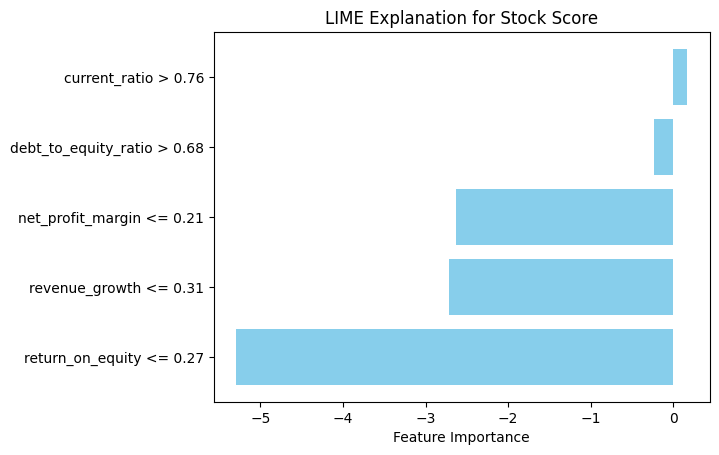

LIME Explanation for TSLA: [('return_on_equity <= 0.27', -5.292805720047593), ('revenue_growth <= 0.31', -2.719275836059346), ('net_profit_margin <= 0.21', -2.628379586803172), ('debt_to_equity_ratio > 0.68', -0.23216525861972076), ('current_ratio > 0.76', 0.16773258558303)]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import lime
from lime.lime_tabular import LimeTabularExplainer
import yfinance as yf
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import concurrent.futures
import time

# Load model and tokenizer once for faster execution
model_name = "distilgpt2"  # Use a smaller, faster model for better performance
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create a Hugging Face pipeline with explicit generation parameters (CPU)
transformers_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=150,
    pad_token_id=50256,
    max_new_tokens=50,
    device=-1  # CPU by default, change to device=0 for GPU
)

# Function to fetch stock data
def fetch_stock_data(ticker):
    stock = yf.Ticker(ticker)
    info = stock.info
    data = {
        "revenue_growth": info.get("revenueGrowth", None),
        "net_profit_margin": info.get("profitMargins", None),
        "debt_to_equity_ratio": info.get("debtToEquity", None),
        "return_on_equity": info.get("returnOnEquity", None),
        "current_ratio": info.get("currentRatio", None)
    }
    return data

# Function to calculate stock score
def calculate_stock_score(stock_data):
    score = 0
    if stock_data["revenue_growth"] is not None:
        score += 30 if stock_data["revenue_growth"] > 0.1 else 15
    if stock_data["net_profit_margin"] is not None:
        score += 25 if stock_data["net_profit_margin"] > 0.2 else 15
    if stock_data["debt_to_equity_ratio"] is not None:
        score += 20 if stock_data["debt_to_equity_ratio"] < 1 else 10
    if stock_data["return_on_equity"] is not None:
        score += 30 if stock_data["return_on_equity"] > 0.15 else 15
    if stock_data["current_ratio"] is not None:
        score += 15 if stock_data["current_ratio"] > 1.5 else 5
    score = min(max(score, 0), 100)
    return score

# Function to analyze stock data using the model
def analyze_stock_data(ticker):
    stock_data = fetch_stock_data(ticker)

    # Handle missing (None) values in stock data
    stock_data = {k: (0 if v is None else v) for k, v in stock_data.items()}

    score = calculate_stock_score(stock_data)  # Get stock score based on data

    # Run the language model to analyze the stock data
    prompt = f"Analyze the following stock data for {ticker}: {stock_data}. The stock score is {score}. Explain which financial factors are most important for the stock's performance and why."
    result = transformers_pipeline(prompt)
    analysis = result[0]["generated_text"]

    # Add breakdown of the score to the analysis for better transparency
    breakdown = f"Breakdown of the score: Revenue Growth = {stock_data['revenue_growth']}, Profit Margin = {stock_data['net_profit_margin']}, Debt-to-Equity = {stock_data['debt_to_equity_ratio']}, etc."
    analysis += "\n\n" + breakdown

    return score, analysis, stock_data

# Function to explain the prediction using LIME
def explain_prediction(stock_data):
    # Replace missing (None) values with defaults
    stock_data = {k: (0 if v is None else v) for k, v in stock_data.items()}

    feature_names = list(stock_data.keys())
    feature_values = list(stock_data.values())
    feature_values_array = np.array(feature_values).reshape(1, -1)

    # Create synthetic training data for LIME
    synthetic_data = np.random.rand(100, len(feature_names))

    def dummy_model(x):
        predictions = []
        for xi in x:
            data_dict = dict(zip(feature_names, xi))
            score = calculate_stock_score(data_dict)
            predictions.append([score])
        return np.array(predictions)

    # LIME Explainer
    explainer = LimeTabularExplainer(
        training_data=synthetic_data,
        feature_names=feature_names,
        mode='regression'
    )
    explanation = explainer.explain_instance(feature_values_array[0], dummy_model, num_features=5)

    # Extract feature importance
    importance = explanation.as_list()

    # Plot explanation
    if importance:
        feature_names, feature_importance = zip(*importance)
        plt.barh(feature_names, feature_importance, color='skyblue')
        plt.xlabel("Feature Importance")
        plt.title("LIME Explanation for Stock Score")
        plt.show()
    else:
        print("No explanation generated.")
    return importance

# Function to analyze multiple stocks in parallel
def analyze_multiple_stocks(tickers):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = executor.map(analyze_stock_data, tickers)
    return list(results)

# Profiling the execution time of each task
def profile_analysis(tickers):
    start = time.time()
    results = analyze_multiple_stocks(tickers)
    print(f"Total analysis time: {time.time() - start:.2f} seconds")
    return results

# Example: Random S&P 500 stock tickers
user_input = input("Enter stock tickers (comma separated): ")
tickers = [ticker.strip().upper() for ticker in user_input.split(",")]

# Run the analysis
results = profile_analysis(tickers)

# Print the results of stock analysis with score
for ticker, (score, analysis, stock_data) in zip(tickers, results):
    print(f"\nAnalysis for {ticker} (Score: {score}):\n{analysis}\n")

    # Generate LIME explanation for the stock score and plot it
    explanation = explain_prediction(stock_data)
    print(f"LIME Explanation for {ticker}: {explanation}")


# **TECHNICAL AGENT**

In [ ]:
!pip install langchain
!pip install transformers
!pip install huggingface_hub


In [ ]:
!pip install ta

In [ ]:
import yfinance as yf
import pandas as pd
import ta
import concurrent.futures
import time
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer

# Load language model and tokenizer
model_name = "distilgpt2"  # Example model name
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create the text generation pipeline
transformers_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=512,
    pad_token_id=50256,
    max_new_tokens=150,
    device=-1  # CPU by default, set device=0 for GPU
)

# Function to fetch historical stock data
def fetch_historical_data(ticker, period='6mo', interval='1d'):
    stock = yf.Ticker(ticker)
    data = stock.history(period=period, interval=interval)
    return data

# Function to calculate technical indicators using `ta` library
def calculate_technical_indicators(data):
    indicators = {}

    # Simple Moving Average (SMA) for 20 and 50 days
    data['SMA20'] = data['Close'].rolling(window=20).mean()
    data['SMA50'] = data['Close'].rolling(window=50).mean()

    # Exponential Moving Average (EMA) for 20 days
    data['EMA20'] = ta.trend.ema_indicator(data['Close'], window=20)

    # Relative Strength Index (RSI) for 14 days
    data['RSI14'] = ta.momentum.rsi(data['Close'], window=14)

    # Moving Average Convergence Divergence (MACD)
    data['MACD'] = ta.trend.macd(data['Close'])
    data['MACD_signal'] = ta.trend.macd_signal(data['Close'])

    # Storing the latest indicator values
    indicators['SMA20'] = data['SMA20'].iloc[-1]
    indicators['SMA50'] = data['SMA50'].iloc[-1]
    indicators['EMA20'] = data['EMA20'].iloc[-1]
    indicators['RSI14'] = data['RSI14'].iloc[-1]
    indicators['MACD'] = data['MACD'].iloc[-1]
    indicators['MACD_signal'] = data['MACD_signal'].iloc[-1]

    return indicators

# Function to calculate a technical score based on indicators
def calculate_technical_score(indicators):
    score = 0

    if indicators['SMA20'] > indicators['SMA50']:
        score += 20
    else:
        score -= 20

    if indicators['RSI14'] > 70:
        score -= 15
    elif indicators['RSI14'] < 30:
        score += 15

    if indicators['MACD'] > indicators['MACD_signal']:
        score += 25
    else:
        score -= 25

    if 30 <= indicators['RSI14'] <= 70:
        score += 10

    score = max(min(score + 50, 100), 0)

    return score

# Function to generate AI-based textual analysis
def generate_textual_analysis(ticker, indicators, score):
    prompt = f"Analyze the following technical indicators for {ticker}: {indicators}. The calculated score is {score}. Provide a professional stock analysis."
    result = transformers_pipeline(prompt)
    analysis = result[0]["generated_text"]
    return analysis

# Function to analyze stock data for a given ticker
def analyze_stock(ticker):
    data = fetch_historical_data(ticker)
    indicators = calculate_technical_indicators(data)
    score = calculate_technical_score(indicators)
    analysis = generate_textual_analysis(ticker, indicators, score)
    return indicators, score, analysis

# Function to analyze multiple stocks in parallel
def analyze_multiple_stocks(tickers):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = executor.map(analyze_stock, tickers)
    return list(results)

# Profiling the execution time of each task
def profile_analysis(tickers):
    start = time.time()
    results = analyze_multiple_stocks(tickers)
    print(f"Total analysis time: {time.time() - start:.2f} seconds")
    return results

# Example: User inputs stock tickers
user_input = input("Enter stock tickers (comma separated): ")
tickers = [ticker.strip().upper() for ticker in user_input.split(",")]

# Run the analysis
results = profile_analysis(tickers)

# Print the results of technical analysis with scores and AI-generated analysis
for ticker, (indicators, score, analysis) in zip(tickers, results):
    print(f"\nTechnical Analysis for {ticker}:")
    print(f"Indicators: {indicators}")
    print(f"Technical Score: {score}")
    print(f"AI Analysis:\n{analysis}\n")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Enter stock tickers (comma separated): TSLA


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=150) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Total analysis time: 1.34 seconds

Technical Analysis for TSLA:
Indicators: {'SMA20': 248.05700073242187, 'SMA50': 241.1836001586914, 'EMA20': 259.08153770195815, 'RSI14': 76.33441931487303, 'MACD': 14.820744695638126, 'MACD_signal': 7.568888337781542}
Technical Score: 80
AI Analysis:
Analyze the following technical indicators for TSLA: {'SMA20': 248.05700073242187, 'SMA50': 241.1836001586914, 'EMA20': 259.08153770195815, 'RSI14': 76.33441931487303, 'MACD': 14.820744695638126, 'MACD_signal': 7.568888337781542}. The calculated score is 80. Provide a professional stock analysis. Sign-up and leave a comment. If you don't agree, please click here.



In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=34f7ee1ac595e80ce2c5e4ef48e236a1f529b8ab6695566f6469e8fc14cae548
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


Enter stock tickers (comma separated): AAPL

Analyzing stock: AAPL

Technical Score for AAPL: 55
Technical Indicators for AAPL: {'SMA20': 227.848291015625, 'SMA50': 226.81944091796876, 'EMA20': 226.7208165090843, 'RSI14': 46.44146803456959, 'MACD': -0.8270418414094252, 'MACD_signal': -0.607025382866353}


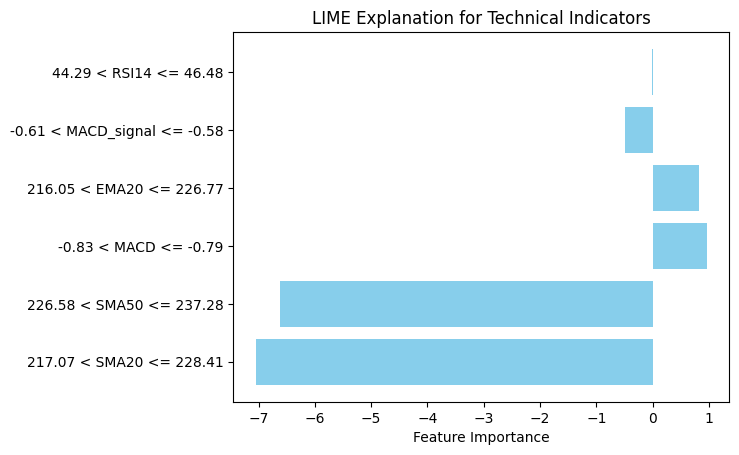

LIME Explanation for AAPL: [('217.07 < SMA20 <= 228.41', -7.047684815525145), ('226.58 < SMA50 <= 237.28', -6.610609025256624), ('-0.83 < MACD <= -0.79', 0.9631110098734088), ('216.05 < EMA20 <= 226.77', 0.8212557014801749), ('-0.61 < MACD_signal <= -0.58', -0.4986519210702873), ('44.29 < RSI14 <= 46.48', -0.012337243425373146)]


In [ ]:
import yfinance as yf
import pandas as pd
import ta
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import RandomForestRegressor

# Function to fetch historical stock data
def fetch_historical_data(ticker, period='6mo', interval='1d'):
    stock = yf.Ticker(ticker)
    data = stock.history(period=period, interval=interval)
    if data.empty:
        raise ValueError(f"No data found for ticker {ticker}.")
    return data

# Function to calculate technical indicators using `ta` library
def calculate_technical_indicators(data):
    data['SMA20'] = data['Close'].rolling(window=20).mean()
    data['SMA50'] = data['Close'].rolling(window=50).mean()
    data['EMA20'] = ta.trend.ema_indicator(data['Close'], window=20)
    data['RSI14'] = ta.momentum.rsi(data['Close'], window=14)
    data['MACD'] = ta.trend.macd(data['Close'])
    data['MACD_signal'] = ta.trend.macd_signal(data['Close'])

    indicators = {
        'SMA20': data['SMA20'].iloc[-1],
        'SMA50': data['SMA50'].iloc[-1],
        'EMA20': data['EMA20'].iloc[-1],
        'RSI14': data['RSI14'].iloc[-1],
        'MACD': data['MACD'].iloc[-1],
        'MACD_signal': data['MACD_signal'].iloc[-1]
    }
    return indicators

# Function to calculate a technical score based on indicators
def calculate_technical_score(indicators):
    score = 0

    if indicators['SMA20'] > indicators['SMA50']:
        score += 20
    else:
        score -= 20

    if indicators['RSI14'] > 70:
        score -= 15
    elif indicators['RSI14'] < 30:
        score += 15

    if indicators['MACD'] > indicators['MACD_signal']:
        score += 25
    else:
        score -= 25

    if 30 <= indicators['RSI14'] <= 70:
        score += 10

    score = max(min(score + 50, 100), 0)  # Normalize score between 0 and 100
    return score

# Function to explain predictions using LIME
def explain_with_lime(indicators, score_function):
    # Prepare features and target
    feature_names = list(indicators.keys())
    feature_values = np.array(list(indicators.values())).reshape(1, -1)

    # Generate synthetic data around the original feature values
    num_samples = 1000
    synthetic_data = np.random.uniform(
        low=0.9, high=1.1, size=(num_samples, len(feature_names))
    ) * feature_values

    # Generate scores for the synthetic data
    synthetic_scores = [
        score_function(dict(zip(feature_names, sample))) for sample in synthetic_data
    ]

    # Train a surrogate model (Random Forest for non-linear approximation)
    surrogate_model = RandomForestRegressor()
    surrogate_model.fit(synthetic_data, synthetic_scores)

    # Initialize LIME explainer
    explainer = LimeTabularExplainer(
        training_data=synthetic_data,
        feature_names=feature_names,
        mode="regression",
        discretize_continuous=True,
    )

    # Explain the specific instance
    explanation = explainer.explain_instance(
        feature_values[0],
        surrogate_model.predict,
        num_features=len(feature_names),
    )

    # Visualize feature importance
    explanation_list = explanation.as_list()
    feature_names, importances = zip(*explanation_list)
    plt.barh(feature_names, importances, color="skyblue")
    plt.xlabel("Feature Importance")
    plt.title("LIME Explanation for Technical Indicators")
    plt.show()

    return explanation_list

# Main function to analyze a stock
def analyze_stock(ticker):
    try:
        # Fetch historical data and calculate indicators
        data = fetch_historical_data(ticker)
        indicators = calculate_technical_indicators(data)

        # Calculate technical score
        score = calculate_technical_score(indicators)
        print(f"\nTechnical Score for {ticker}: {score}")
        print(f"Technical Indicators for {ticker}: {indicators}")

        # Explain the score using LIME
        explanation = explain_with_lime(indicators, calculate_technical_score)
        print(f"LIME Explanation for {ticker}: {explanation}")

    except Exception as e:
        print(f"Error analyzing {ticker}: {e}")

# Example: User inputs stock tickers
if __name__ == "__main__":
    user_input = input("Enter stock tickers (comma separated): ")
    tickers = [ticker.strip().upper() for ticker in user_input.split(",")]

    for ticker in tickers:
        print(f"\nAnalyzing stock: {ticker}")
        analyze_stock(ticker)


# SENTIMENTAL ANALYZER AGENT


In [ ]:
import pandas as pd
from transformers import pipeline
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Initialize the FinBERT model for sentiment analysis using pipeline
sentiment_analyzer = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")  # This will use CPU by default
  # Use GPU if available

# Download necessary NLTK resources

nltk.data.path = ['/root/nltk_data']  # Ensure it uses a known directory

# Try downloading the necessary resources again
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


# Sentiment-indicating words (can be expanded)
positive_words = ['growth', 'increase', 'profit', 'surge', 'positive', 'gain', 'upward', 'optimism', 'boost']
negative_words = ['decline', 'loss', 'drop', 'fall', 'negative', 'decrease', 'downward', 'uncertain', 'losses']
neutral_words = ['stable', 'steady', 'unchanged', 'flat', 'consistent']

# Initialize lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lower case
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]  # Remove stopwords and non-alphabetic tokens
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in tokens]  # Lemmatize tokens
    return ' '.join(lemmatized_tokens)

# Function to simulate fetching news data for a stock ticker
def fetch_stock_news(ticker):
    sample_news = [
        f"{ticker} hits all-time high as market sentiment remains positive.",
        f"{ticker} stock sees decline due to global market uncertainty.",
        f"{ticker} reports record-breaking quarterly revenue growth.",
        f"Analysts question {ticker}'s long-term viability amid rising competition."
    ]
    return sample_news

# Function to calculate the sentiment score based on sentiment-indicating words
def calculate_word_based_sentiment(text):
    tokens = word_tokenize(text.lower())
    positive_count = sum(1 for word in tokens if word in positive_words)
    negative_count = sum(1 for word in tokens if word in negative_words)
    neutral_count = sum(1 for word in tokens if word in neutral_words)

    # Simple score calculation based on word counts
    total_words = len(tokens)
    if total_words == 0:
        return 0  # Avoid division by zero

    positive_score = positive_count / total_words
    negative_score = negative_count / total_words
    neutral_score = neutral_count / total_words

    return positive_score, negative_score, neutral_score

# Function to combine the keyword-based scoring with FinBERT sentiment analysis
def analyze_sentiment(news_data):
    # Perform sentiment analysis using FinBERT (with domain-specific understanding)
    bert_results = sentiment_analyzer(news_data)

    # Calculate sentiment score using word-based method
    word_based_scores = [calculate_word_based_sentiment(news) for news in news_data]

    return bert_results, word_based_scores

# Function to calculate the overall sentiment score
def calculate_sentimental_score(ticker):
    news_data = fetch_stock_news(ticker)  # Fetch news for the ticker

    # Perform sentiment analysis (both FinBERT and word-based analysis)
    bert_results, word_based_scores = analyze_sentiment(news_data)

    # Aggregate sentiment scores from both approaches
    scores = {"Positive": 0, "Neutral": 0, "Negative": 0}

    for result, word_scores in zip(bert_results, word_based_scores):
        # From FinBERT
        label = result['label']
        score = result['score']
        scores[label] += score

        # From keyword-based scoring
        positive_score, negative_score, neutral_score = word_scores
        scores["Positive"] += positive_score
        scores["Negative"] += negative_score
        scores["Neutral"] += neutral_score

    # Normalize scores and calculate final sentiment score
    total_scores = sum(scores.values())
    if total_scores == 0:
        return 0, scores  # Avoid division by zero

    normalized_scores = {key: val / total_scores for key, val in scores.items()}
    sentimental_score = (normalized_scores["Positive"] - normalized_scores["Negative"])

    return sentimental_score, scores

# Main function to run the sentiment analysis on user input ticker
def sentiment_analysis_agent():
    ticker = input("Enter the stock ticker symbol: ").upper()  # User inputs the ticker symbol
    score, scores_detail = calculate_sentimental_score(ticker)
    print(f"Sentimental Score for {ticker}: {score}")
    scaled_score = round(score * 100)

    # Display the results
    print(f"Sentimental Score for {ticker}: {scaled_score} / 100")
    print("Detailed Sentiment Scores:", scores_detail)

# Run the agent with user input
sentiment_analysis_agent()


Enter the stock ticker symbol: TSLA
Sentimental Score for TSLA: -0.25
Sentimental Score for TSLA: -25 / 100
Detailed Sentiment Scores: {'Positive': 0.5, 'Neutral': 1.0, 'Negative': 1.5}


Enter the stock ticker symbol: TSLA


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Sentimental Score for TSLA: -0.25
Sentimental Score for TSLA: -25 / 100
Detailed Sentiment Scores: {'Positive': 0.5, 'Neutral': 1.0, 'Negative': 1.5}

Explanation for news 1:
Sentiment: Positive
Positive Keywords: ['high']
Negative Keywords: []
Neutral Keywords: ['market']

Explanation for news 2:
Sentiment: Negative
Positive Keywords: []
Negative Keywords: ['decline']
Neutral Keywords: ['market']

Explanation for news 3:
Sentiment: Neutral
Positive Keywords: []
Negative Keywords: []
Neutral Keywords: ['reports', 'quarterly']

Explanation for news 4:
Sentiment: Negative
Positive Keywords: []
Negative Keywords: ['question']
Neutral Keywords: []


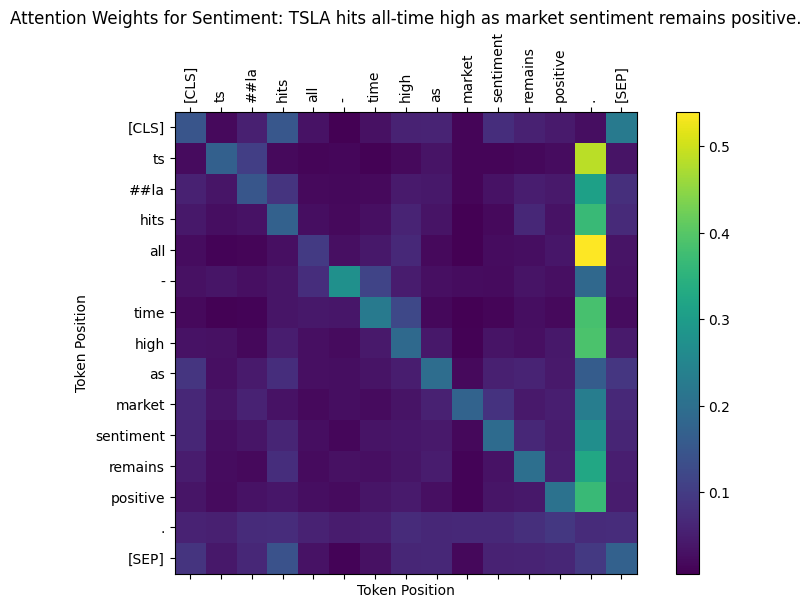

In [ ]:
import pandas as pd
from transformers import pipeline, BertTokenizer, BertForSequenceClassification
import torch
import matplotlib.pyplot as plt
import numpy as np

# Initialize the FinBERT model and tokenizer for sentiment analysis
sentiment_analyzer = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")
tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone", output_attentions=True)

# Define lists of keywords for sentiment analysis
positive_keywords = ["growth", "record", "high", "positive", "success", "increase", "rise", "up", "surge"]
negative_keywords = ["decline", "uncertainty", "loss", "drop", "fall", "decrease", "risk", "loss", "question"]
neutral_keywords = ["reports", "announces", "quarterly", "new", "update", "market"]

# Function to simulate fetching news data for a stock ticker
def fetch_stock_news(ticker):
    # Sample news headlines for demonstration
    sample_news = [
        f"{ticker} hits all-time high as market sentiment remains positive.",
        f"{ticker} stock sees decline due to global market uncertainty.",
        f"{ticker} reports record-breaking quarterly revenue growth.",
        f"Analysts question {ticker}'s long-term viability amid rising competition."
    ]
    return sample_news

# Function to analyze sentiment based on keyword matches and return explanations
def analyze_sentiment_based_on_keywords(text):
    words = text.lower().split()
    positive_matches = [word for word in words if word in positive_keywords]
    negative_matches = [word for word in words if word in negative_keywords]
    neutral_matches = [word for word in words if word in neutral_keywords]

    if len(positive_matches) > len(negative_matches):
        sentiment_label = "Positive"
        sentiment_score = len(positive_matches) / (len(positive_matches) + len(negative_matches) + len(neutral_matches))
    elif len(negative_matches) > len(positive_matches):
        sentiment_label = "Negative"
        sentiment_score = len(negative_matches) / (len(positive_matches) + len(negative_matches) + len(neutral_matches))
    else:
        sentiment_label = "Neutral"
        sentiment_score = len(neutral_matches) / (len(positive_matches) + len(negative_matches) + len(neutral_matches))

    explanation = {
        "sentiment": sentiment_label,
        "positive_matches": positive_matches,
        "negative_matches": negative_matches,
        "neutral_matches": neutral_matches
    }

    return sentiment_label, sentiment_score, explanation

# Function to perform sentiment analysis using the FinBERT model
def analyze_sentiment_using_finbert(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs, output_attentions=True)  # Ensure attention weights are returned

    if outputs.attentions is None:
        raise ValueError("Model did not return attention weights. Check if the model supports outputting attention weights.")

    logits = outputs.logits
    attentions = outputs.attentions  # This will contain the attention layers

    sentiment_label = torch.argmax(logits).item()
    sentiment_score = torch.softmax(logits, dim=-1).max().item()

    # Convert numerical sentiment_label to string
    sentiment_labels = ["Negative", "Neutral", "Positive"]
    sentiment_label_str = sentiment_labels[sentiment_label]

    explanation = {
        "sentiment": sentiment_label_str,
        "confidence_score": sentiment_score,
        "tokens": inputs["input_ids"],
        "logits": logits.tolist(),
        "attentions": attentions  # Include the attention weights
    }

    return sentiment_label_str, sentiment_score, explanation

# Function to calculate the sentimental score for a given stock ticker
def calculate_sentimental_score(ticker):
    news_data = fetch_stock_news(ticker)  # Fetch news for the ticker

    sentiments = []
    explanations = []

    for news in news_data:
        sentiment_label, sentiment_score, explanation = analyze_sentiment_based_on_keywords(news)
        sentiments.append((sentiment_label, sentiment_score))
        explanations.append(explanation)

    # Aggregate sentiment scores for positive, neutral, and negative categories
    scores = {"Positive": 0, "Neutral": 0, "Negative": 0}
    for label, score in sentiments:
        scores[label] += score

    sentimental_score = (scores["Positive"] - scores["Negative"]) / len(sentiments)

    # Returning sentiment score along with detailed explanations and news data
    return sentimental_score, scores, explanations, news_data

# Function to visualize the attention weights from the FinBERT model
def visualize_attention_weights(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs, output_attentions=True)  # Ensure attention weights are returned

    if outputs.attentions is None:
        raise ValueError("Model did not return attention weights.")

    attentions = outputs.attentions[-1]  # Get the last attention layer

    # Remove padding tokens
    input_ids = inputs["input_ids"].squeeze().tolist()
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    attention_mask = inputs['attention_mask'].squeeze().tolist()  # Get the attention mask

    # Filter out attention for padding tokens
    valid_token_indices = [i for i, mask in enumerate(attention_mask) if mask != 0]
    tokens = [tokens[i] for i in valid_token_indices]

    # Handle attention weights (shape: [batch_size, num_heads, seq_len, seq_len])
    attentions = attentions.squeeze(0)  # Squeeze the batch dimension
    attentions = attentions.mean(dim=0)  # Average across all heads to simplify

    attentions = attentions.detach().numpy()  # Convert to numpy array

    # Select relevant rows and columns of attentions (excluding padding tokens)
    attentions = attentions[valid_token_indices, :][:, valid_token_indices]  # Subset attentions matrix

    # Plot attention weights
    fig, ax = plt.subplots(figsize=(10, 6))
    cax = ax.matshow(attentions, cmap='viridis')
    plt.colorbar(cax)
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90)
    ax.set_yticklabels(tokens)
    ax.set_xlabel('Token Position')
    ax.set_ylabel('Token Position')
    plt.title(f"Attention Weights for Sentiment: {text}")
    plt.show()

# Main function to run the sentiment analysis on user input ticker
def sentiment_analysis_agent():
    ticker = input("Enter the stock ticker symbol: ").upper()  # User inputs the ticker symbol
    score, scores_detail, explanations, news_data = calculate_sentimental_score(ticker)

    print(f"Sentimental Score for {ticker}: {score}")
    scaled_score = round(score * 100)

    # Display the results
    print(f"Sentimental Score for {ticker}: {scaled_score} / 100")
    print("Detailed Sentiment Scores:", scores_detail)

    # Show keyword-based explanations
    for idx, explanation in enumerate(explanations):
        print(f"\nExplanation for news {idx+1}:")
        print(f"Sentiment: {explanation['sentiment']}")
        print(f"Positive Keywords: {explanation['positive_matches']}")
        print(f"Negative Keywords: {explanation['negative_matches']}")
        print(f"Neutral Keywords: {explanation['neutral_matches']}")

    # Optionally, visualize attention weights for one of the news headlines
    visualize_attention_weights(news_data[0])

# Run the agent with user input
sentiment_analysis_agent()


In [ ]:
!pip install streamlit pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.9 MB/s eta 0:00:00


In [ ]:


# Write a simple Streamlit app
%%writefile app.py
import streamlit as st

st.title('Hello Streamlit!')
st.write("Welcome to Streamlit running on Google Colab.")

# Use ngrok to tunnel the Streamlit app
from pyngrok import ngrok

# Set up the Streamlit port
public_url = ngrok.connect(8501)
print('Streamlit app is live at:', public_url)

# Run Streamlit app
!streamlit run app.py


Overwriting app.py
